In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.spatial import ConvexHull
import scanpy.external as sce
import scanpy as sc
import scipy

from importlib import reload

# locals
import utils as ut
import plotting as plt2

# Load iHSC data

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.var_names = adata.var['gene_name'].values
adata

AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

# DEG

In [3]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="cluster_str",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    key_added='cluster_deg',
)

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='cluster_deg',
)

deg.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,C1,ZNF416,59.107777,2.441200,0.0,0.0,0.999491,0.869284
1,C1,IL4I1,54.698078,1.929153,0.0,0.0,1.000000,0.942623
2,C1,ZFP82,53.811306,1.988346,0.0,0.0,0.998217,0.837144
3,C1,UBE2S,53.667488,2.156020,0.0,0.0,0.996690,0.828516
4,C1,LRG1,52.178192,2.069696,0.0,0.0,0.989305,0.707722


sig.shape=(1924, 8)


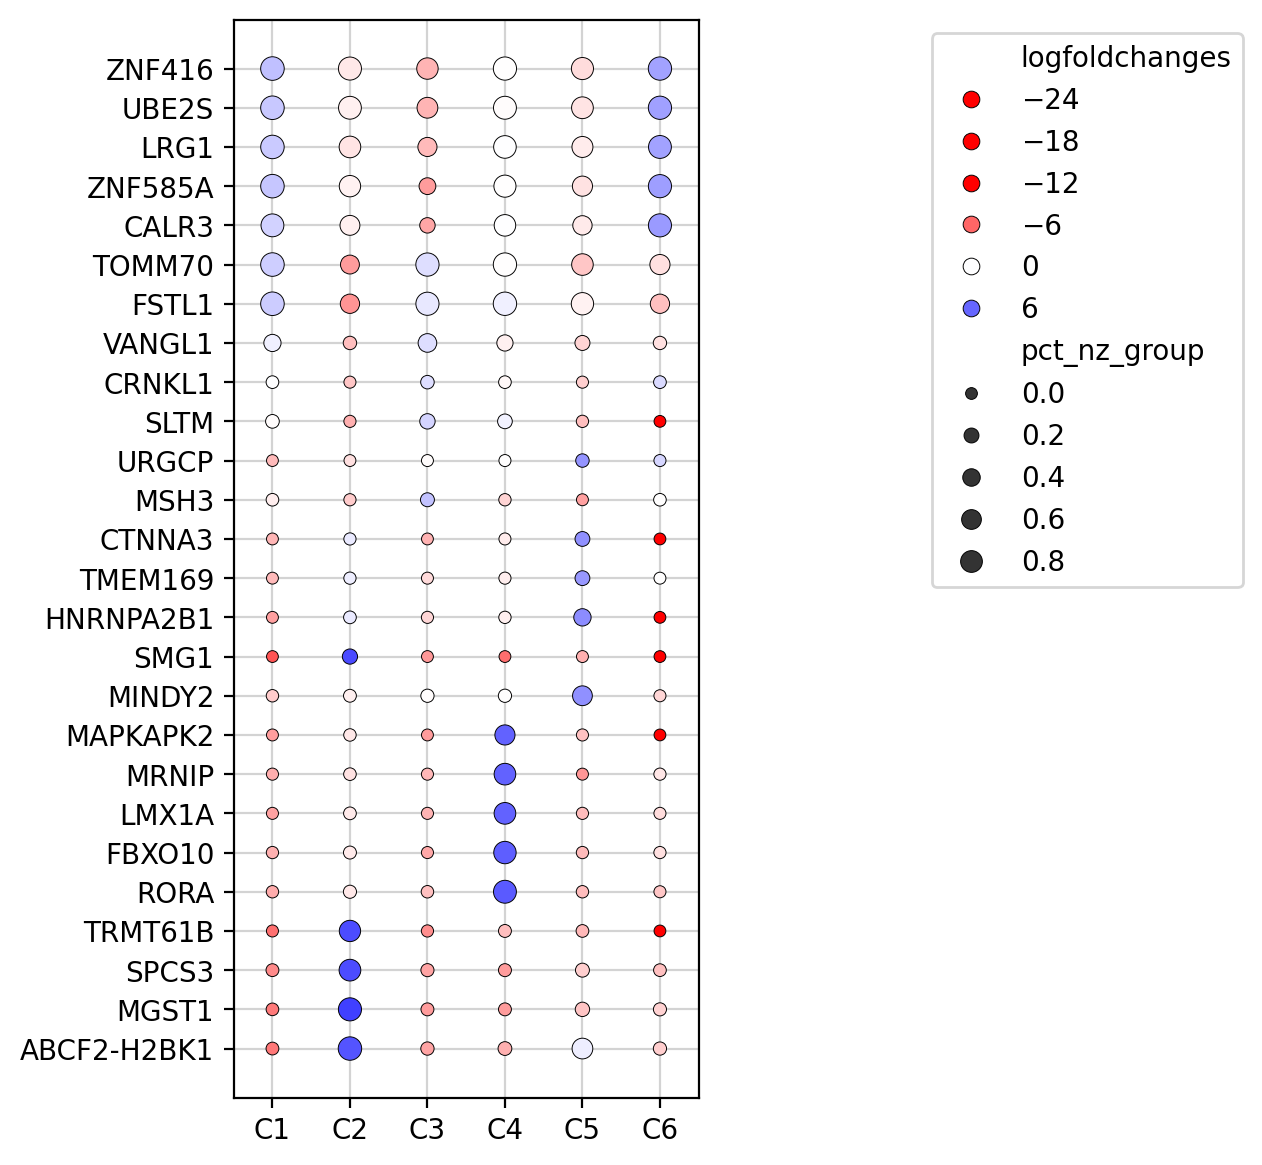

In [39]:
sig = deg.copy()
n_genes = 5
alpha = 0.01
sig = sig[sig['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > 1.0].reset_index(drop=True)

sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

print(f"{sig.shape=}")

gene_list = sig.groupby('group').head(n_genes)['names'].unique()
sig = deg[deg['names'].isin(gene_list)].copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 7


sns.scatterplot(
    data=sig,
    y='names',
    x='group',
    ec='k',
    hue='logfoldchanges',
    palette='bwr_r',
    hue_norm=(-10, 10),
    size='pct_nz_group',
    zorder=3,
)

y_margin = 0.05  # 10% margin on top and bottom
x_margin = 0.1
plt.gca().margins(y=y_margin, x=x_margin) 

plt.grid(
    True, 
    c='lightgrey',
    zorder=0,
)

plt.ylabel("")
plt.xlabel("")

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title='',
    bbox_to_anchor=(2.2, 1),   
)

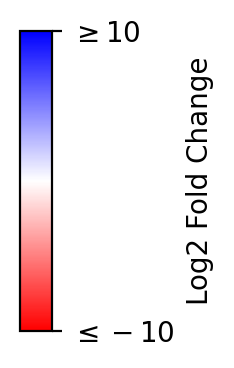

In [16]:
plt2.make_colorbar(
    cmap='bwr_r', 
    title="Log2 Fold Change",
    tick_labels=[r"$\leq -10$", r"$\geq 10$"]
)

In [6]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Transcription Factors

sig.shape=(414, 8)


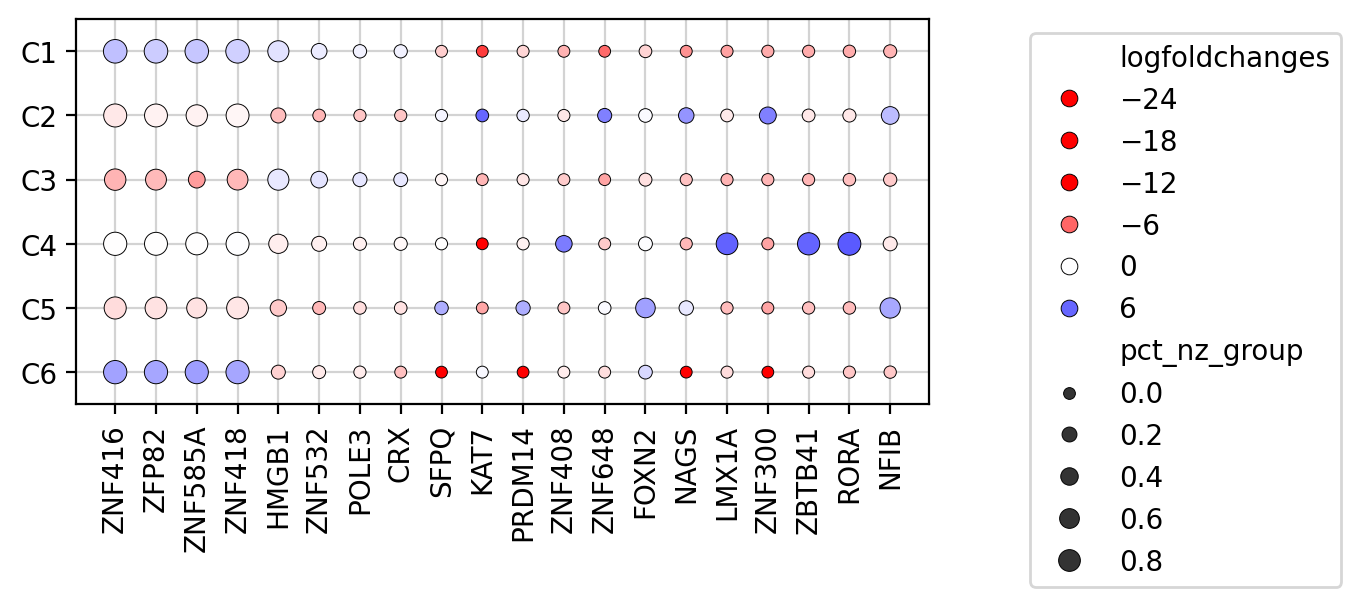

In [18]:
sig = deg.copy()
n_genes = 4
alpha = 0.01
logfoldchanges = 0.5

tf_list = adata.uns['scenic_transcription_factors']['gene_name'].to_list()

sig = sig[sig['names'].isin(tf_list)]
sig = sig[sig['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > logfoldchanges].reset_index(drop=True)


sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

print(f"{sig.shape=}")

gene_list = sig.groupby('group').head(n_genes)['names'].unique()
sig = deg[deg['names'].isin(gene_list)].copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5.5, 2.5

sns.scatterplot(
    data=sig,
    x='names',
    y='group',
    ec='k',
    hue='logfoldchanges',
    palette='bwr_r',
    hue_norm=(-10, 10),
    size='pct_nz_group',
    zorder=3,
)

y_margin = 0.1  # 10% margin on top and bottom
plt.gca().margins(y=y_margin) 

plt.grid(
    True, 
    c='lightgrey',
    zorder=0,
)

plt.ylabel("")
plt.xlabel("")

plt.gca().tick_params(axis='x', rotation=90)

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title='',
    bbox_to_anchor=(1.5, 1),   
)

# HSC Genes

sig.shape=(28, 8)


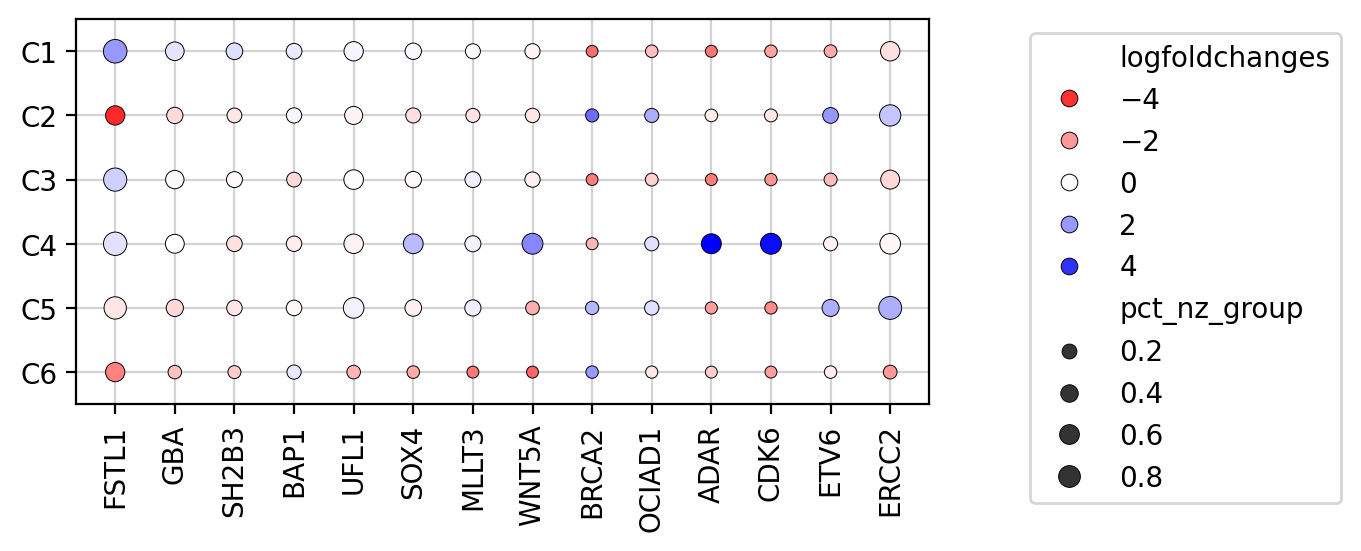

In [19]:
sig = deg.copy()
n_genes = 4
alpha = 0.05
logfoldchanges = 0.25

hsc_genes = list(adata.uns['go_annotations']['gene_name'].unique())


sig = sig[sig['names'].isin(hsc_genes)]
sig = sig[sig['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > logfoldchanges].reset_index(drop=True)

sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

print(f"{sig.shape=}")

gene_list = sig.groupby('group').head(n_genes)['names'].unique()
sig = deg[deg['names'].isin(gene_list)].copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5.5, 2.5

sns.scatterplot(
    data=sig,
    x='names',
    y='group',
    ec='k',
    hue='logfoldchanges',
    palette='bwr_r',
    hue_norm=(-5, 5),
    size='pct_nz_group',
    zorder=3,
)

y_margin = 0.1  # 10% margin on top and bottom
plt.gca().margins(y=y_margin) 

plt.grid(
    True, 
    c='lightgrey',
    zorder=0,
)

plt.ylabel("")
plt.xlabel("")

plt.gca().tick_params(axis='x', rotation=90)

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title='',
    bbox_to_anchor=(1.5, 1),   
)

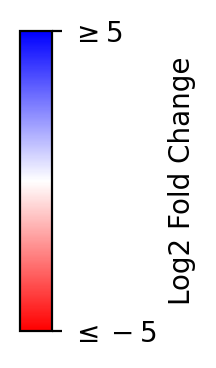

In [20]:
plt2.make_colorbar(
    cmap='bwr_r', 
    title="Log2 Fold Change",
    tick_labels=[r"$\leq -5$", r"$\geq 5$"]
)

In [ ]:
break